# Deep Image Prior SAR Image Anonymization - Proof Of Concept
We'll use the [DIP](https://dmitryulyanov.github.io/deep_image_prior) to anonymize an amplitude SAR image through inpainting.  
The notebook is a proof of concept, used to simply check on the fly if the method is able to generalize credible inpaintings on data with a strong difference wrt natural images (i.e., will it be able for instance of generating speckle noise and other typical SAR degradation phenomena?).  
The notebook is derived from the [following](https://github.com/DmitryUlyanov/deep-image-prior/blob/master/inpainting.ipynb) of the original DIP repository.  
We work directly on Sentinel-1 GRD sample.

## Import libs

In [1]:
from __future__ import print_function
import cv2
import numpy as np
import torch
import torch.optim
import time
from typing import List
from utils.inpainting_utils import *
import os
import glob
import argparse
from utils.isplutils import tiff_to_float32, to8, make_dir_tag
from utils.slack import ISPLSlack
from models import create_network
import pandas as pd
from utils.data import SEN12MSS1InpaintingDatasetFolder, load_SEN12MS_s1_raster, S1Normalize
from torchvision.transforms import ToTensor, Compose
from utils.utils import select_loss
from utils.pytorch_ssim import SSIM
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import cv2
from matplotlib import rc
rc('text', usetex=True)
rc('font',**{'family': 'Trebuchet MS'})

## Helpers functions

In [2]:
# Helpers functions and classes

class OptimizationRoutine:
    """
    Class for the optimization routine (needed to be called in the optimize function)
    """
    def __init__(self, net: nn.Module, net_input_saved: torch.Tensor, reg_noise_std: float,
                 noise: torch.Tensor, mask_var: torch.Tensor, img_var: torch.Tensor, loss: nn.Module,#loss_1: nn.Module, loss_2: nn.Module, loss_balance: float, 
                 param_noise: bool, log_int: int = 0, num_iter: int = 100):
        self.net = net
        self.net_input_saved = net_input_saved
        self.reg_noise_std = reg_noise_std
        self.noise = noise
        self.mask_var = mask_var
        self.img_var = img_var
        #self.loss_1 = loss_1
        #self.loss_2 = loss_2
        #self.loss_balance = loss_balance
        self.loss = loss
        self.param_noise = param_noise
        self.log_int = log_int
        self.num_iter = num_iter

    def closure(self, it: int):

        if self.param_noise:
            for n in [x for x in self.net.parameters() if len(x.size()) == 4]:
                n = n + n.detach().clone().normal_() * n.std() / 50

        net_input = self.net_input_saved
        if self.reg_noise_std > 0:
            net_input = self.net_input_saved + (self.noise.normal_() * self.reg_noise_std)

        out = self.net(net_input)

        # Watch out for the signs of the losses!
        if self.loss.__class__ == SSIM:
            #print('The loss is SSIM!')
            total_loss = -self.loss(out*self.mask_var, self.img_var*self.mask_var)
        else:
            total_loss = self.loss(out*self.mask_var, self.img_var*self.mask_var)
        total_loss.backward()

        print('Iteration %05d    Loss %f' % (it, total_loss.item()), '\r', end='')

        return total_loss, out


def optimize(optimizer_type, parameters, routine: OptimizationRoutine, lr: float, num_iter: int,
             schedule_lr_patience: int = None, schedule_lr_factor: float = None) -> [List[float], List[np.array]]:
    """
    Runs optimization loop.

    Args:
        optimizer_type: 'adam' or 'sgd'
        parameters: list of Tensors to optimize over
        routine: OptimizationRoutine instance, with the closure function that returns loss variable
        lr: learning rate
        num_iter: number of iterations
        schedule_lr_patience: LR scheduler patience
        schedule_lr_factor: LR scheduler factor
        img_name: name of the image, used for logging a different section for each sample
    """
    
    losses, dip_imgs = [], []
    if optimizer_type == 'adam':
        # Instantiate the optimizer and scheduler
        optimizer = torch.optim.Adam(parameters, lr=lr)
        if schedule_lr_patience:
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=schedule_lr_factor,
                                                                   patience=schedule_lr_patience, min_lr=1e-8)

        # Optimization loop #
        for j in range(num_iter):
            optimizer.zero_grad(set_to_none=True)
            loss, it_images = routine.closure(j)
            optimizer.step()
            if schedule_lr_patience:
                scheduler.step(loss)
            # Logging
            if (j % routine.log_int) == 0:
                losses.append(loss)
                dip_imgs.append(it_images)

    elif optimizer_type == 'sgd':
        # Instantiate optimization and scheduler
        optimizer = torch.optim.SGD(parameters, lr=lr,
                                    momentum=0, dampening=0, weight_decay=0, nesterov=False)
        if schedule_lr_patience:
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=schedule_lr_factor,
                                                                   patience=schedule_lr_patience, min_lr=1e-8)
        # Optimization loop #
        for j in range(num_iter):
            # optimizer.zero_grad(set_to_none=True)
            optimizer.zero_grad()
            loss, it_images = routine.closure(j)
            optimizer.step()
            if schedule_lr_patience:
                scheduler.step(loss)
            # Logging
            if (j % routine.log_int) == 0:
                losses.append(loss)
                dip_imgs.append(it_images)

    else:
        assert False
        
    return losses, dip_imgs

## Execution parameters

### Deep Image Prior (DIP) parameters

In [3]:
# Optimization hyperparams
max_iter = 6001
show_every = 250
figsize = 8
reg_noise_std = 0.00
param_noise = True
lr = 0.001
lr_patience = 250
lr_factor = 1e-1
log_int = 500
# DIP hyperparams
pad = 'reflection' # 'zero'
OPT_OVER = 'net'
optimizer = 'adam'
net_type = 'Unet' # one of skip_depth4|skip_depth2|Unet|ResNet
input_type = 'noise'
input_depth = 1
upsample = 'deconv'
activation = 'ReLU'
noise_dist = 'uniform'
noise_range = '-4:4'
noise_std = 1

### Engine parameters

In [4]:
# Set the engine to be used
gpu = 1
os.environ['CUDA_VISIBLE_DEVICES'] = '{}'.format(gpu)

### Data parameters

In [5]:
# Image params
img_path = 'data/orig.tiff'
mask_path = 'data/inp_mask.png'

## Process the image
Let's load the sample and mask and look at them.

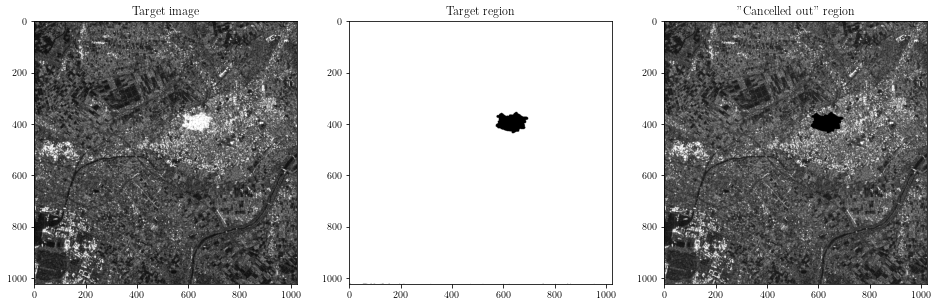

In [65]:
# --- Load the sample and mask

# Target sample
img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED).astype(np.float32)
# Image normalization
img_float = np.asarray(img, dtype=np.float32) / (
                2 ** 16 - 1)  # normalize the range [0, 2**16-1] to [0, 1]
img_float *= 100  # scale values as the maximum is still too small
img_float = np.clip(img_float, a_min=0, a_max=1)  # clip values in range [0, 1]

# Inpainting mask
mask = cv2.resize(cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE), img.shape)>127
mask = mask.astype(np.uint8)*255
mask -= 255
mask[mask==255] = 1
mask = mask.astype(np.float32)

# Plot them to be sure of doing the right thing
fig, axs = plt.subplots(1, 3, figsize=(16, 8))
axs[0].imshow(img, cmap='gray')
axs[0].set_title('Target image')
axs[1].imshow(mask, cmap='gray')
axs[1].set_title('Target region')
axs[2].imshow(img*mask, cmap='gray')
axs[2].set_title('"Cancelled out" region')
plt.show()

## Let's inpaint it
The whole process is nothing different from a classic inpainting task.
We will optimize a starting noise input by processing it with the network, optimizing the network's weight according to the selected loss function and using the inpainting mask to "cancel" the target region from the loss computation.
In this way, the network will be forced to create some "original" image content to fill up the target region in the anonymized sample, using as context the rest of the input.

In [7]:
# Datatype for conversion and delivering on the GPU
dtype = torch.cuda.FloatTensor

# Get the DIP DONE!
net_input = get_noise(input_depth=input_depth, method='noise',
                      spatial_size=img.shape, noise_type=noise_dist,
                      var=noise_std, noise_range=noise_range).type(dtype)
net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()
# Convert the image and mask
img_float = torch.tensor(img_float).type(dtype).unsqueeze(0).unsqueeze(0)
mask_t = torch.tensor(mask).type(dtype).unsqueeze(0).unsqueeze(0)
#mask = torch.ones_like(img_float)
# Create the network
net = create_network(net_name=net_type, input_depth=1,
                     pad=pad, upsample=upsample,
                     activation=activation, need_sigmoid=True,
                     num_channels=1, dtype=dtype)

# Instantiate the optimization routine
routine = OptimizationRoutine(net=net, net_input_saved=net_input_saved, reg_noise_std=noise_std,
                              noise=noise, mask_var=mask_t, img_var=img_float, loss=select_loss('ssim', dtype),
                              param_noise=param_noise, log_int=log_int, num_iter=max_iter)
# OPTIMIZATION LOOP #
p = get_params('net', routine.net, net_input)
tic = time.time()  # log time for optimization
losses, dip_imgs = optimize(optimizer_type=optimizer, parameters=p, routine=routine, lr=lr,
                            num_iter=max_iter, schedule_lr_patience=lr_patience, 
                            schedule_lr_factor=lr_factor)
toc = time.time()
# Compute PSNR as an additional metric
out_img = net(net_input).detach().cpu().numpy()

reflection
reflection
reflection
reflection
reflection
reflection
reflection
reflection
reflection
reflection
reflection


## Done! Let's see the inpainted "anonymized" image

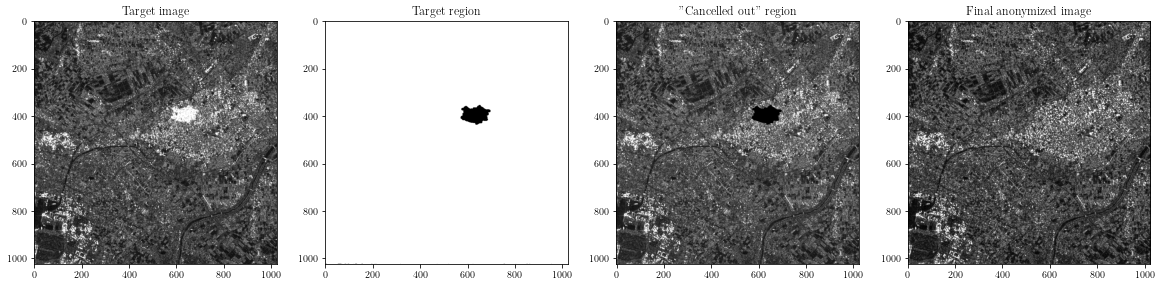

In [66]:
# Plot them to be sure of doing the right thing
fig, axs = plt.subplots(1, 4, figsize=(20, 8))
axs[0].imshow(img, cmap='gray')
axs[0].set_title('Target image')
axs[1].imshow(mask, cmap='gray')
axs[1].set_title('Target region')
axs[2].imshow(img*mask, cmap='gray')
axs[2].set_title('"Cancelled out" region')
axs[3].imshow(out_img[0][0], cmap='gray')
axs[3].set_title('Final anonymized image')
plt.show()

### Let's have a closer look

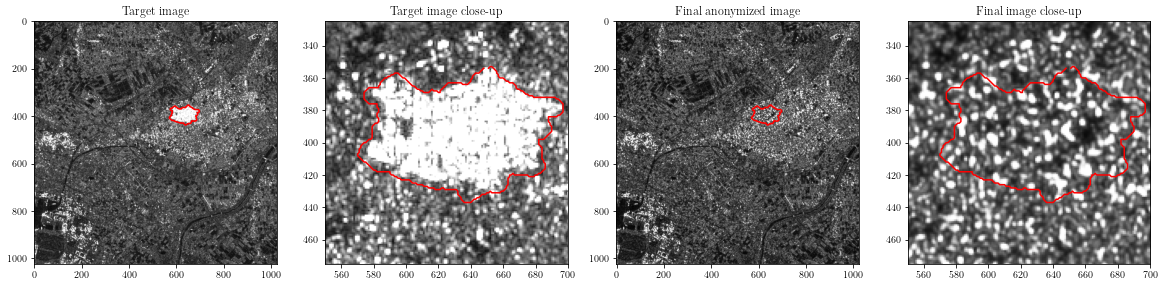

In [67]:
# Find the borders of the target region
img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED).astype(np.float32)
mask_orig = cv2.resize(cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE), img.shape)
edges = cv2.Canny(mask_orig, 100, 200)

# Find the contours
contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Plot everything
fig, axs = plt.subplots(1, 4, figsize=(20, 8))
axs[0].imshow(img, cmap='gray')
axs[0].plot(contours[-1][:, :, 0].flatten(), contours[-1][:, :, 1].flatten(), color='red')
axs[0].set_title('Target image')
axs[1].imshow(img, cmap='gray')
axs[1].plot(contours[-1][:, :, 0].flatten(), contours[-1][:, :, 1].flatten(), color='red')
axs[1].set_xlim(550, 700)
axs[1].set_ylim(475, 325)
axs[1].set_title('Target image close-up')
axs[2].imshow(out_img[0][0], cmap='gray')
axs[2].plot(contours[-1][:, :, 0].flatten(), contours[-1][:, :, 1].flatten(), color='red')
axs[2].set_title('Final anonymized image')
axs[3].imshow(out_img[0][0], cmap='gray')
axs[3].plot(contours[-1][:, :, 0].flatten(), contours[-1][:, :, 1].flatten(), color='red')
axs[3].set_xlim(550, 700)
axs[3].set_ylim(475, 325)
axs[3].set_title('Final image close-up')
plt.show()

## Wanna create a nice looking GIF for the whole process?
We have all of them saved in a list `dip_img`!  
Let's just save them and then plot them with matplotlib to create a GIF.

In [61]:
# Convert the Tensors into numpy arrays
if torch.is_tensor(dip_imgs[0]):
    dip_imgs = [img.detach().cpu().squeeze().numpy() for img in dip_imgs]

# Prepare the directory
save_dir = '../assets/dip_gif_animation'  # CHANGE YOUR DESTINATION FOLDER HERE if you want anther one!
os.makedirs(save_dir, exist_ok=True)

# Save the images
if torch.is_tensor(img):
    img = img.detach().cpu().squeeze().numpy()
    mask = mask.detach().cpu().squeeze().numpy()
for idx, dip_img in enumerate(dip_imgs):
    # Convert to uint8
    dip_img = (dip_img-np.nanmin(dip_img))/(np.nanmax(dip_img)-np.nanmin(dip_img))
    dip_img = (dip_img*255).astype(np.uint8)
    # Save
    cv2.imwrite(os.path.join(save_dir, f'dip_iter_{idx*log_int}.png'), dip_img)

### Let's create the animation GIF starting from the saved images

In [90]:
# func which will be applied in order to create a video frame
def func(frame_idx, ax, current_samples, log_int, fontsize, inp_coords):
    from matplotlib.patches import Rectangle
    
    ax.clear()
    # density will displayed value in an normalized way
    ax.imshow(current_samples[frame_idx], cmap='gray')
    ax.axis('off')
    if frame_idx == 0:
        ax.set_title('Starting noise input', fontsize=fontsize)
    elif frame_idx == 12:
        ax.plot(inp_coords[:, :, 0].flatten(), inp_coords[:, :, 1].flatten(), color='red')
        ax.text(inp_coords[0, 0, 0]-150, inp_coords[0, 0, 1]-50, 'Target\nregion', color='red', fontsize=40)
        ax.set_title('Final anonymized image', fontsize=fontsize)
    else:
        ax.set_title(f'DIP generated image iteration {frame_idx*log_int}', fontsize=fontsize)

    return ax

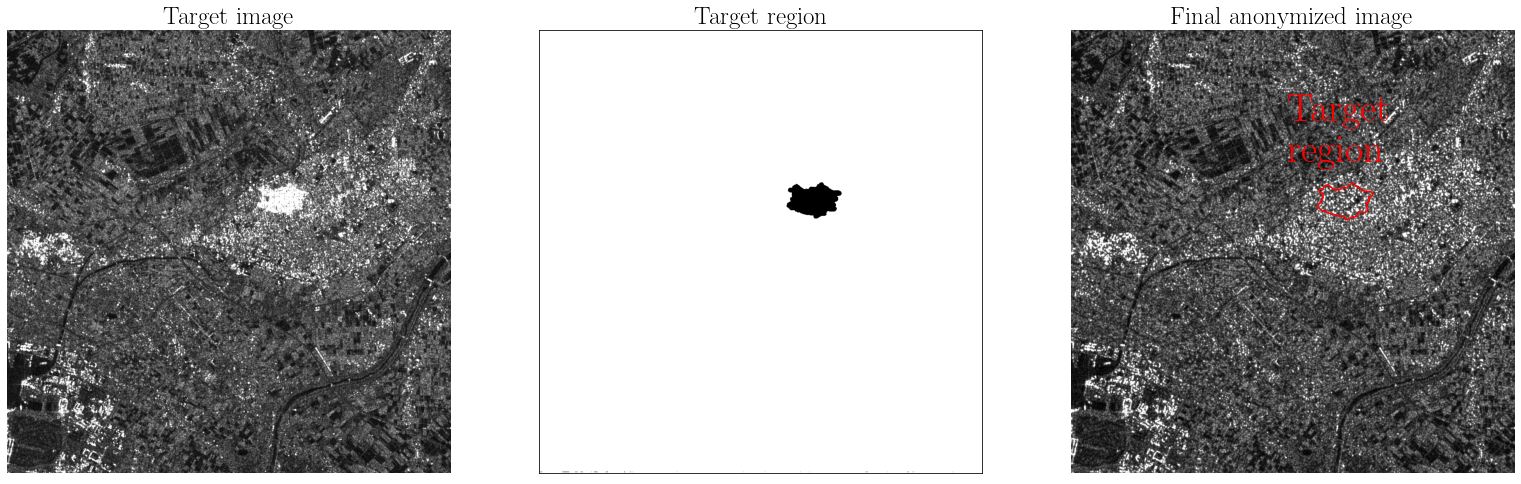

In [91]:
import matplotlib.animation as animation
fsize = 25

# Load images
root_dir = save_dir
idxs = np.arange(0, 6000+log_int, log_int)
frames = [cv2.imread(os.path.join(root_dir, f'dip_iter_{idx}.png'), cv2.IMREAD_UNCHANGED) for idx in idxs]

# Prepare figure
fig, axs = plt.subplots(1, 3, figsize=(27, 9))
axs[0].imshow(img, cmap='gray')
axs[0].axis('off')
axs[0].set_title('Target image', fontsize=fsize)
axs[1].imshow(mask, cmap='gray')
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_title('Target region', fontsize=fsize)

# Create the animation
gif = animation.FuncAnimation(fig, func, range(len(frames)), interval=1000,
                              repeat_delay=10, blit=False,
                              fargs=(axs[2], frames, 500, fsize, contours[-1]))

gif.save(os.path.join(root_dir, 'DIP_iteration_progress.gif'))

### Let's display it
The `gif.save()` command will display the last frame only.

In [92]:
from IPython.display import HTML

# custom html attributes set when lauching the video
HTML('<img src="{}">'.format(os.path.join(root_dir, 'DIP_iteration_progress.gif')))